# <span style="color:black"> Titanic - Machine Learning from Disaster </span>
Please see the corresponding [kaggle](https://www.kaggle.com/competitions/titanic) link for the details.

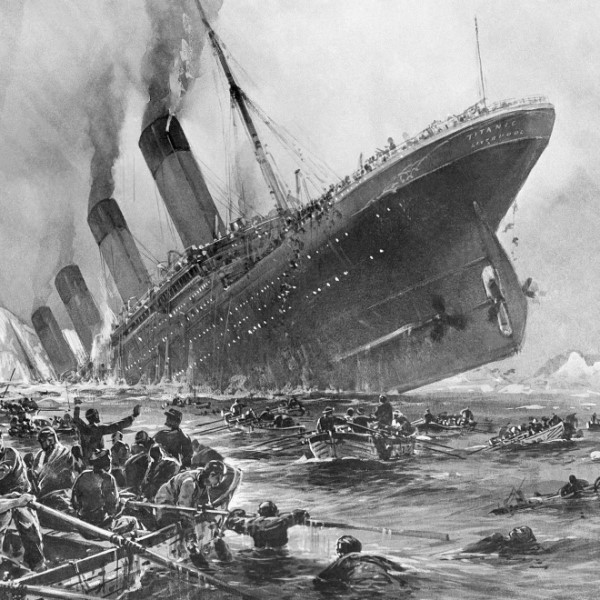

# <span style="color:green"> DATA </span>

In [73]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 14})
import seaborn as sns

## Train data

In [74]:
data_train = pd.read_csv("train.csv")
data_test = pd.read_csv("test.csv")
data_train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


# <span style="color:green"> DATA ANALYSIS </span>

In [75]:
print(f"total data shape: {data_train.shape}")

def unique_features(data):
    nums = []# unique possibilities for each feature
    for feature in data.columns:
        num = len(data.loc[:,feature].unique())
        nums.append(num)
        print(f"feature {feature:11s}: unique values = {num}")
        
unique_features(data_train)

total data shape: (891, 12)
feature PassengerId: unique values = 891
feature Survived   : unique values = 2
feature Pclass     : unique values = 3
feature Name       : unique values = 891
feature Sex        : unique values = 2
feature Age        : unique values = 89
feature SibSp      : unique values = 7
feature Parch      : unique values = 7
feature Ticket     : unique values = 681
feature Fare       : unique values = 248
feature Cabin      : unique values = 148
feature Embarked   : unique values = 4


**Note:** It is safe, I think, to assume that PassengerID, Name, and Ticket number have no contribution to the problem. I investigate the impact of other features below.

## **Pclass**

In [76]:
data_train.value_counts('Pclass')

Pclass
3    491
1    216
2    184
dtype: int64

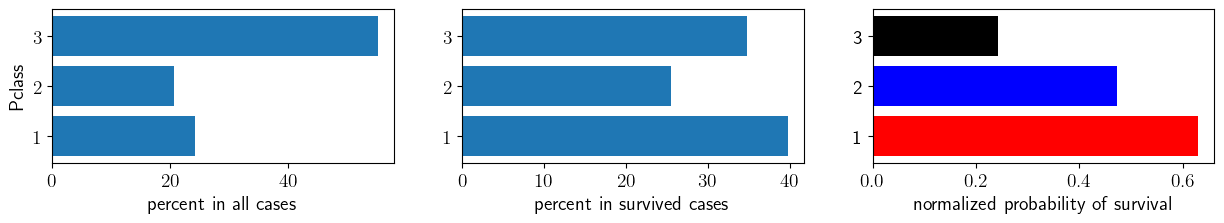

In [77]:
def barplots(feature,data):
    feature_counts = data.value_counts(feature).sort_index()
    fig, ax = plt.subplots(1, 3, figsize=(15, 2))
    fig.subplots_adjust(wspace=0.2)
    ax = ax.flatten()
    ax[0].barh(feature_counts.index,feature_counts.values/data.shape[0]*100)
    ax[0].set_xlabel('percent in all cases')

    survived_by_feature = data.groupby(feature, as_index=True)['Survived'].sum()
    total_survived_cases = data_train.loc[:,'Survived'].sum()
    ax[1].barh(survived_by_feature.index,survived_by_feature.values/total_survived_cases*100)
    ax[1].set_xlabel('percent in survived cases')

    return survived_by_feature, feature_counts, ax, fig

survived_by_feature, feature_counts, ax, fig = barplots('Pclass',data_train)

normalized_probability = [survived_by_feature[1]/feature_counts[1],
                          survived_by_feature[2]/feature_counts[2],
                          survived_by_feature[3]/feature_counts[3]]
ax[2].barh(['1','2','3'],np.array(normalized_probability),color=['red', 'blue', 'black'])
ax[2].set_xlabel('normalized probability of survival')
ax[0].set_ylabel('Pclass')

plt.show()

In [78]:
correlation = data_train['Pclass'].corr(data_train['Survived'])
print(f"correlation of Survival with Pclass is {correlation:.4f}")

correlation of Survival with Pclass is -0.3385


## **Sex**

In [79]:
data_train.value_counts('Sex')

Sex
male      577
female    314
dtype: int64

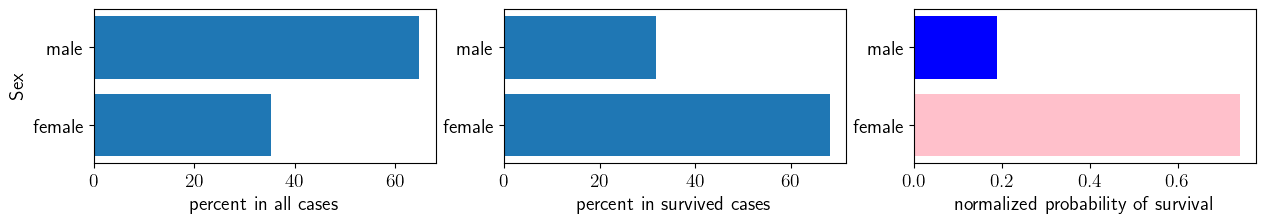

In [80]:
survived_by_feature, feature_counts, ax, fig = barplots('Sex',data_train)

normalized_probability = [survived_by_feature['female']/feature_counts['female'],
                          survived_by_feature['male']/feature_counts['male']]
ax[2].barh(['female','male'],np.array(normalized_probability),color=['pink', 'blue'])
ax[2].set_xlabel('normalized probability of survival')
ax[0].set_ylabel('Sex')

plt.show()

### An alternative approach

In [81]:
survived_men = data_train.loc[data_train['Sex'] == 'male']['Survived']
print(f"percent of men survived = {sum(survived_men)/len(survived_men)*100:.2f}")
survived_women = data_train.loc[data_train['Sex'] == 'female']['Survived']
print(f"percent of women survived = {sum(survived_women)/len(survived_women)*100:.2f}")

percent of men survived = 18.89
percent of women survived = 74.20


### Sex to numerical value

In [82]:
def sex_to_num(sex):
    if sex == 'female':
        return 0
    else:
        return 1

data_train['Sex'] = data_train['Sex'].apply(sex_to_num)
data_test['Sex'] = data_test['Sex'].apply(sex_to_num)

In [83]:
correlation = data_train['Sex'].corr(data_train['Survived'])
print(f"correlation of Survival with Sex is {correlation:.4f}")

correlation of Survival with Sex is -0.5434


## **Age**

In [84]:
data_train.value_counts('Age',dropna=False)

Age
NaN      177
24.00     30
22.00     27
18.00     26
30.00     25
        ... 
24.50      1
0.67       1
0.92       1
36.50      1
0.42       1
Length: 89, dtype: int64

**Note:** There are many NaN values for the age. I can simply drop this feature or replace all the NaN values with for example and average age. I take the second route below.

In [85]:
mean_Age = data_train['Age'].mean()
data_train['Age'] = data_train['Age'].fillna(mean_Age)
data_test['Age'] = data_test['Age'].fillna(mean_Age)
age_data = data_train.value_counts('Age',dropna=False)

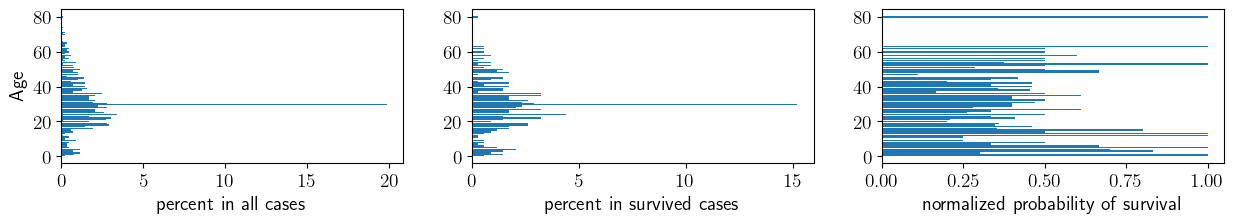

In [86]:
survived_by_feature, feature_counts, ax, fig = barplots('Age',data_train)

normalized_probability = []
for i in feature_counts.index:
    normalized_probability.append(survived_by_feature[i]/feature_counts[i])

ax[2].barh(feature_counts.index,np.array(normalized_probability))
ax[2].set_xlabel('normalized probability of survival')
ax[0].set_ylabel('Age')
plt.setp(ax, yticks=range(0,100,20))

plt.show()


In [87]:
correlation = data_train['Age'].corr(data_train['Survived'])
print(f"correlation of Survival with Age is {correlation:.4f}")

correlation of Survival with Age is -0.0698


## **SibSp: number of siblings/spouses aboard the Titanic)**

In [88]:
data_train.value_counts('SibSp').sort_index()

SibSp
0    608
1    209
2     28
3     16
4     18
5      5
8      7
dtype: int64

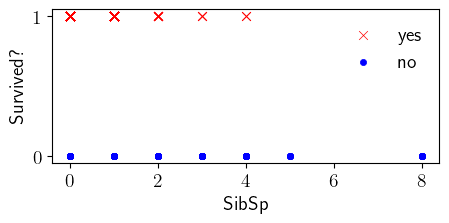

In [89]:
yes = data_train.loc[:,'Survived'] == 1
no = data_train.loc[:,'Survived'] == 0
def cont_plot(feature):
    plt.figure(figsize=(5,2))
    plt.scatter(data_train.loc[yes,feature],np.ones(yes.sum()),marker='x',color='r',s=40,linewidth=0.5,label='yes')
    plt.scatter(data_train.loc[no,feature],np.zeros(no.sum()),marker='o',color='b',s=20,linewidth=0.5,label='no')
    plt.xlabel(feature)
    plt.ylabel('Survived?')
    plt.yticks([0,1])
    plt.legend(frameon=False)
    plt.show()
    
cont_plot('SibSp')

In [90]:
correlation = data_train['SibSp'].corr(data_train['Survived'])
print(f"correlation of Survival with SibSp is {correlation:.4f}")

correlation of Survival with SibSp is -0.0353


## **Parch: number of parents/children aboard the Titanic)**

In [91]:
data_train.value_counts('Parch')

Parch
0    678
1    118
2     80
3      5
5      5
4      4
6      1
dtype: int64

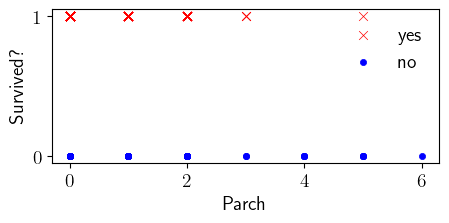

In [92]:
cont_plot('Parch')

In [93]:
correlation = data_train['Parch'].corr(data_train['Survived'])
print(f"correlation of Survival with Parch is {correlation:.4f}")

correlation of Survival with Parch is 0.0816


## **Fare**

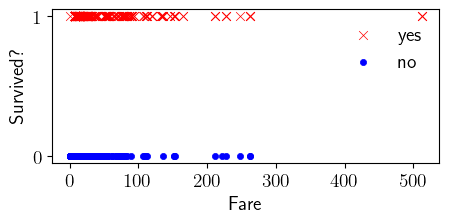

In [94]:
cont_plot('Fare')

In [95]:
correlation = data_train['Fare'].corr(data_train['Survived'])
print(f"correlation of Survival with Fare is {correlation:.4f}")

correlation of Survival with Fare is 0.2573


## **Cabin**

In [96]:
data_train.value_counts('Cabin',dropna=False)

Cabin
NaN            687
C23 C25 C27      4
B96 B98          4
G6               4
E101             3
              ... 
C62 C64          1
C54              1
B39              1
C50              1
A10              1
Length: 148, dtype: int64

**Note:** Very little data is available on cabins. We could drop it but below we show that a majority of the passengers with NaN cabin did not survive. So, it might be an important factor.

In [97]:
NaNs = data_train[(data_train.Cabin.isna())]
NaNs_survived = data_train[(data_train.Cabin.isna()) & (data_train.Survived==1)]
print(f"fraction of passengers with NaN cabin survived = {NaNs_survived.shape[0]/NaNs.shape[0]}")

fraction of passengers with NaN cabin survived = 0.29985443959243085


**Note:** Below, we assign a letter to NaN cabins and group other cabins by their first letter.

In [98]:
data_train['Cabin'] = data_train['Cabin'].fillna('N')
data_test['Cabin'] = data_test['Cabin'].fillna('N')
def group_cabin(cabin):
    if ((cabin == 'N') or (cabin[0] == 'T')):
        return 'N'
    else:
        return cabin[0]
    
data_train['Cabin'] = data_train['Cabin'].apply(group_cabin)
data_test['Cabin'] = data_test['Cabin'].apply(group_cabin)
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,N,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C,C
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,N,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C,S
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,N,S


In [99]:
data_train.Cabin.value_counts()

N    688
C     59
B     47
D     33
E     32
A     15
F     13
G      4
Name: Cabin, dtype: int64

## **Embarked**

In [100]:
data_train.value_counts('Embarked',dropna=False)

Embarked
S      644
C      168
Q       77
NaN      2
dtype: int64

**Note:** Since there are only 2 NaN values in the Embarked column, I remove those rows from the data frame.

In [101]:
index_nanEmbarked = data_train[data_train.Embarked.isna()].index.values
data_train = data_train.drop(index_nanEmbarked)
data_train.value_counts('Embarked',dropna=False)

Embarked
S    644
C    168
Q     77
dtype: int64

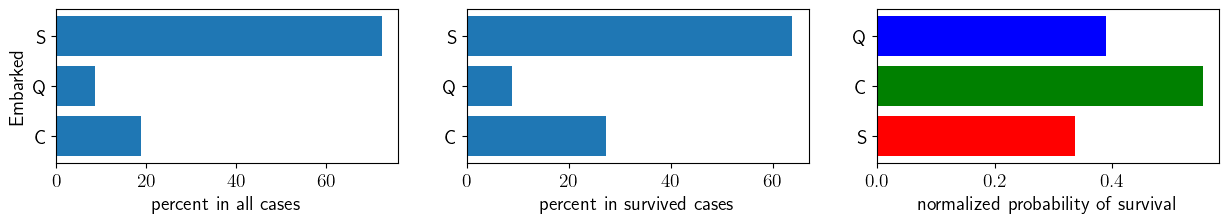

In [102]:
survived_by_feature, feature_counts, ax, fig = barplots('Embarked',data_train)

normalized_probability = [survived_by_feature['S']/feature_counts['S'],
                          survived_by_feature['C']/feature_counts['C'],
                          survived_by_feature['Q']/feature_counts['Q']]
ax[2].barh(['S','C','Q'],np.array(normalized_probability),color=['red','green','blue'])
ax[2].set_xlabel('normalized probability of survival')
ax[0].set_ylabel('Embarked')

plt.show()

## DATA ANALYSIS CONCLUSION

## Normalize Age and Fair data

In [103]:
mean_Age, std_Age = data_train.Age.mean(), data_train.Age.std()
mean_Fare, std_Fare = data_train.Fare.mean(), data_train.Fare.std()
data_train.Age = (data_train.Age-mean_Age)/std_Age
data_train.Fare = (data_train.Fare-mean_Fare)/std_Fare

data_test.Age = (data_test.Age-mean_Age)/std_Age
data_test.Fare = (data_test.Fare-mean_Fare)/std_Fare

data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,-0.590163,1,0,A/5 21171,-0.499958,N,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,0.643609,1,0,PC 17599,0.788503,C,C
2,3,1,3,"Heikkinen, Miss. Laina",0,-0.281720,0,0,STON/O2. 3101282,-0.486376,N,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,0.412277,1,0,113803,0.422623,C,S
4,5,0,3,"Allen, Mr. William Henry",1,0.412277,0,0,373450,-0.483861,N,S


In [104]:
data_train_Cleaned = data_train.drop(columns=['PassengerId','Name','Ticket'])
data_test_Cleaned = data_test.drop(columns=['Name','Ticket'])
data_train_Cleaned.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,1,-0.590163,1,0,-0.499958,N,S
1,1,1,0,0.643609,1,0,0.788503,C,C
2,1,3,0,-0.281720,0,0,-0.486376,N,S
3,1,1,0,0.412277,1,0,0.422623,C,S
4,0,3,1,0.412277,0,0,-0.483861,N,S
5,0,3,1,0.003522,0,0,-0.475645,N,Q
6,0,1,1,1.877380,0,0,0.397723,E,S
7,0,3,1,-2.132377,3,1,-0.221775,N,S
8,1,3,0,-0.204609,0,2,-0.421820,N,S
9,1,2,0,-1.207048,1,0,-0.040764,N,C


## One-hot encoding

In [105]:
cat_features = ['Pclass','Embarked','Cabin']
print(f"The multiclass categorical features are:\n{cat_features}")
data_train_OHE = pd.get_dummies(data = data_train_Cleaned, prefix = cat_features, columns = cat_features)
data_test_OHE = pd.get_dummies(data = data_test_Cleaned, prefix = cat_features, columns = cat_features)

features = [x for x in data_train_OHE.columns if x != 'Survived']
print(f"total number of features after one-hot encoding: {len(features)}")

The multiclass categorical features are:
['Pclass', 'Embarked', 'Cabin']
total number of features after one-hot encoding: 19


## Correllation

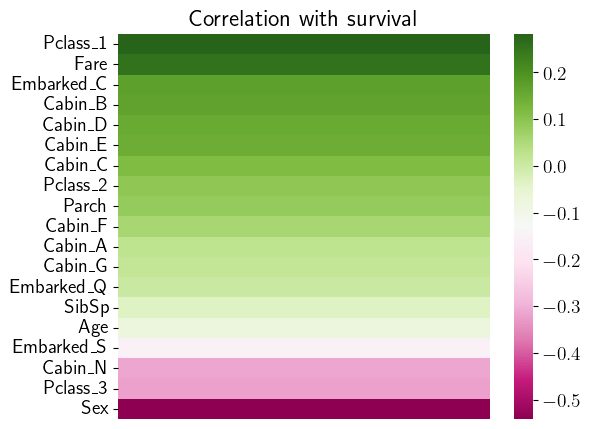

,Survived,Sex,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_N
0,0,1,-0.590163,1,0,-0.499958,0,0,1,0,0,1,0,0,0,0,0,0,0,1
1,1,0,0.643609,1,0,0.788503,1,0,0,1,0,0,0,0,1,0,0,0,0,0
2,1,0,-0.281720,0,0,-0.486376,0,0,1,0,0,1,0,0,0,0,0,0,0,1
3,1,0,0.412277,1,0,0.422623,1,0,0,0,0,1,0,0,1,0,0,0,0,0
4,0,1,0.412277,0,0,-0.483861,0,0,1,0,0,1,0,0,0,0,0,0,0,1
5,0,1,0.003522,0,0,-0.475645,0,0,1,0,1,0,0,0,0,0,0,0,0,1
6,0,1,1.877380,0,0,0.397723,1,0,0,0,0,1,0,0,0,0,1,0,0,0
7,0,1,-2.132377,3,1,-0.221775,0,0,1,0,0,1,0,0,0,0,0,0,0,1
8,1,0,-0.204609,0,2,-0.421820,0,0,1,0,0,1,0,0,0,0,0,0,0,1
9,1,0,-1.207048,1,0,-0.040764,0,1,0,1,0,0,0,0,0,0,0,0,0,1


In [106]:
corr = data_train_OHE.corr().loc[:,'Survived']
corr = corr.sort_values(ascending=False)

plt.figure(figsize=(6,5))
sns.heatmap(corr.iloc[1:].to_frame(), cmap="PiYG", xticklabels=False, yticklabels=True)
plt.title('Correlation with survival')
plt.show()

data_train_OHE.head(10)

# <span style="color:green"> MACHINE LEARNING </span>

In [107]:
from sklearn.model_selection import train_test_split
X_train, X_dev, y_train, y_dev = train_test_split(data_train_OHE[features],data_train_OHE['Survived'],train_size=0.8, random_state=1)
print(f"X_train.shape = {X_train.shape}, X_dev.shape = {X_dev.shape}")
print(f"y_train.shape = {y_train.shape}, y_dev.shape = {y_dev.shape}")

X_train.shape = (711, 19), X_dev.shape = (178, 19)
y_train.shape = (711,), y_dev.shape = (178,)


## <span style="color:blue"> Logistic Regression </span>

In [108]:
model_LG = LogisticRegression()
model_LG.fit(X_train, y_train)
trainAcc_LG = accuracy_score(model_LG.predict(X_train),y_train)*100
devAcc_LG = accuracy_score(model_LG.predict(X_dev),y_dev)*100
print(f"Logistic Regression:\n train accuracy = {trainAcc_LG:.2f}%, dev accuracy = {devAcc_LG:.2f}%")

Logistic Regression:
 train accuracy = 80.87%, dev accuracy = 85.39%


## <span style="color:blue"> Random Forest </span>

In [109]:
model_RF = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model_RF.fit(X_train, y_train)
trainAcc_RF = accuracy_score(model_RF.predict(X_train),y_train)*100
devAcc_RF = accuracy_score(model_RF.predict(X_dev),y_dev)*100
print(f"Random Forest:\n train accuracy = {trainAcc_RF:.2f}%, dev accuracy = {devAcc_RF:.2f}%")

Random Forest:
 train accuracy = 86.92%, dev accuracy = 82.58%


## <span style="color:blue"> XGBoost </span>

In [110]:
n_estimators = 1000
early_stopping_rounds = 20
learning_rate = 0.1
max_depth = 6
lambda_ = 3
model_XGB = XGBClassifier(n_estimators = n_estimators, learning_rate = learning_rate,
                          verbosity = 0, random_state = 1, early_stopping_rounds = early_stopping_rounds,
                          max_depth = max_depth,reg_alpha=lambda_)
model_XGB.fit(X_train,y_train, eval_set=[(X_train, y_train), (X_dev, y_dev)],verbose=False)

print(f"XGBoost:\n train accuracy = {accuracy_score(model_XGB.predict(X_train),y_train)*100:.2f}, dev accuracy = {accuracy_score(model_XGB.predict(X_dev),y_dev)*100:.2f}%")

XGBoost:
 train accuracy = 88.47, dev accuracy = 84.27%


# <span style="color:green"> TEST DATA </span>

In [399]:
data_test_Cleaned.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,892,3,1,0.373721,0,0,-0.488304,N,Q
1,893,3,0,1.337605,1,0,-0.504989,N,S
2,894,2,1,2.494266,0,0,-0.450912,N,Q
3,895,3,1,-0.204609,0,0,-0.471536,N,S
4,896,3,0,-0.590163,1,1,-0.398595,N,S


In [400]:
data_test_OHE.head()

,PassengerId,Sex,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_N
0,892,1,0.373721,0,0,-0.488304,0,0,1,0,1,0,0,0,0,0,0,0,0,1
1,893,0,1.337605,1,0,-0.504989,0,0,1,0,0,1,0,0,0,0,0,0,0,1
2,894,1,2.494266,0,0,-0.450912,0,1,0,0,1,0,0,0,0,0,0,0,0,1
3,895,1,-0.204609,0,0,-0.471536,0,0,1,0,0,1,0,0,0,0,0,0,0,1
4,896,0,-0.590163,1,1,-0.398595,0,0,1,0,0,1,0,0,0,0,0,0,0,1


### See if there are NaN data in the test

In [401]:
data_test_OHE.isna().sum()

PassengerId    0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           1
Pclass_1       0
Pclass_2       0
Pclass_3       0
Embarked_C     0
Embarked_Q     0
Embarked_S     0
Cabin_A        0
Cabin_B        0
Cabin_C        0
Cabin_D        0
Cabin_E        0
Cabin_F        0
Cabin_G        0
Cabin_N        0
dtype: int64

In [402]:
data_test_OHE['Fare'] = data_test_OHE['Fare'].fillna(mean_Fare)

In [403]:
X_test = data_test_OHE[features]
X_test.head()

,Sex,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_N
0,1,0.373721,0,0,-0.488304,0,0,1,0,1,0,0,0,0,0,0,0,0,1
1,0,1.337605,1,0,-0.504989,0,0,1,0,0,1,0,0,0,0,0,0,0,1
2,1,2.494266,0,0,-0.450912,0,1,0,0,1,0,0,0,0,0,0,0,0,1
3,1,-0.204609,0,0,-0.471536,0,0,1,0,0,1,0,0,0,0,0,0,0,1
4,0,-0.590163,1,1,-0.398595,0,0,1,0,0,1,0,0,0,0,0,0,0,1


In [561]:
predictions = model_XGB.predict(X_test)
output = pd.DataFrame({'PassengerId': data_test.PassengerId, 'Survived': predictions})
output.head(10)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [437]:
pred_LG = model_LG.predict(X_test)
pred_RF = model_RF.predict(X_test)
pred_XGB = model_XGB.predict(X_test)
preds = np.c_[pred_LG,pred_RF,pred_XGB]
ave = np.mean(preds,axis=1)
predictions = np.zeros(len(ave),dtype=int)
for i in range(len(ave)):
    if ave[i] > 0.5:
        predictions[i] = 1

In [438]:
output = pd.DataFrame({'PassengerId': data_test.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)